In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os


ModuleNotFoundError: No module named 'pycrs'

In [2]:
dirpath = "..\*\*"

# Make a search criteria to select the DEM files
search_criteria = "*.tif"

q = os.path.join(dirpath, search_criteria)
print(q)
paths=glob.glob(q)
print(paths)

src_files_to_mosaic = []
for fp in paths:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src) 

print(src_files_to_mosaic)

mosaic, out_trans = merge(src_files_to_mosaic)

..\*\*\*.tif
['..\\Joymap\\srtm_21_10\\srtm_21_10.tif', '..\\Joymap\\srtm_21_11\\srtm_21_11.tif', '..\\Joymap\\srtm_21_12\\srtm_21_12.tif', '..\\Joymap\\srtm_21_13\\srtm_21_13.tif', '..\\Joymap\\srtm_22_10\\srtm_22_10.tif', '..\\Joymap\\srtm_22_11\\srtm_22_11.tif', '..\\Joymap\\srtm_22_12\\srtm_22_12.tif', '..\\Joymap\\srtm_22_13\\srtm_22_13.tif', '..\\Joymap\\srtm_23_10\\srtm_23_10.tif', '..\\Joymap\\srtm_23_11\\srtm_23_11.tif', '..\\Joymap\\srtm_23_12\\srtm_23_12.tif', '..\\Joymap\\srtm_23_13\\srtm_23_13.tif']
[<open DatasetReader name='..\Joymap\srtm_21_10\srtm_21_10.tif' mode='r'>, <open DatasetReader name='..\Joymap\srtm_21_11\srtm_21_11.tif' mode='r'>, <open DatasetReader name='..\Joymap\srtm_21_12\srtm_21_12.tif' mode='r'>, <open DatasetReader name='..\Joymap\srtm_21_13\srtm_21_13.tif' mode='r'>, <open DatasetReader name='..\Joymap\srtm_22_10\srtm_22_10.tif' mode='r'>, <open DatasetReader name='..\Joymap\srtm_22_11\srtm_22_11.tif' mode='r'>, <open DatasetReader name='..\Joymap\s

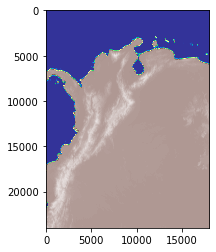

In [3]:
%matplotlib inline
show(mosaic, cmap='terrain')

In [4]:
crs="epsg:4326"
out_meta = src.meta.copy()
out_fp="output.tif"

# Update the metadata
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": crs
})

with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)


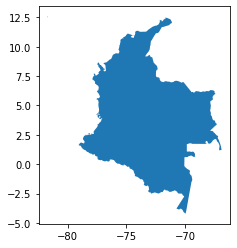

In [5]:
#import tiff map to numpy array

Z=gpd.read_file("500k_2016_V1_shp\Shapefile\country\country.shp",crs=crs)
# Z=Z.to_crs(crs)
COL=Z[Z["CNTRY_NAME"]=="Colombia"]

# print(Z)
COL.plot(legend=True)
plt.show()

In [6]:
print(COL.crs)
print(COL.to_crs(crs).crs)

epsg:4326
epsg:4326


In [7]:
import json
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords = getFeatures(COL)

In [9]:
from rasterio.mask import mask
data = rasterio.open("output.tif")
out_img, out_transform = mask(data, shapes=coords, crop=True)

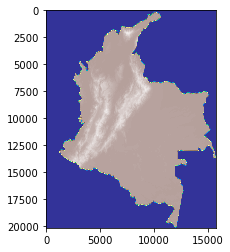

In [10]:
show(out_img, cmap='terrain')

In [15]:
import pycrs

out_meta = data.meta.copy()
epsg_code = int(data.crs.data['init'][5:])
out_meta.update({
        "driver": "GTiff",
        "height": out_img.shape[1],
        "width": out_img.shape[2],
        "transform": out_transform,
        "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
    })
with rasterio.open("col.tif", "w", **out_meta) as dest:
    dest.write(out_img)